First implementation of a trajectory transformer, where each observation is a vector of [t, x, y, sog, cog]

In [87]:
import numpy as np 
import torch
import torch.nn as nn
import torch.functional as f
import pickle 
import matplotlib.pyplot as plt


In [88]:
# Parameters (could move to config file if wanna be fancy)

d_model = 128 # Size of the embedding space
max_len = 40 # Maximum number of observations per trajectory
input_dim = 4 # [ lat, lon, sog, cog]
output_dim = 4 # [t, lat, lon, sog, cog]
n_enc_layers = 6 
n_dec_layers = n_enc_layers
n_heads = 4 # number of attentionheads in the encoder and decoder
d_ff = 512 # Dimension of the ff nn at the end of a block
d_latent = 32 # Dimension of the latent space (Perhaps uneccesary)
segment_length = 10 # Sliding window length if we want to use this over the avg across all time
    
torch.pi = torch.acos(torch.zeros(1)).item() *2 # Define pi (not sure why tho)

In [89]:
class PositionalEncoding(nn.Module):
    """
    Postional encoder using the sinusiodals from the original paper
    """
    
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0).transpose(0,1)
        self.pe =  pe # self.pe is a matrix where the first dim is T, second is batch, and third is model/embdedding dim

    def forward(self, x):
        # We will overlay the positional encoding on the input. Take only x.size(0) in case we have shorter seqs.
        x = x + self.pe[:x.size(0), :]
        return x
    

class TrajectoryEncoder(nn.Module):
    """
    Basic Encoder relying mainly on pytorchs modules 
    """
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len, 
                 d_latent, segment_length):
        super(TrajectoryEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model) # Project from input dim to embedding dim
        self.pos_enc = PositionalEncoding(d_model, max_len) # Apply the positional encoding to the embedded features
        enc_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff) # Create the encoder layers and the encoder stack from torchs own modules
        self.transformer_encoder = nn.TransformerEncoder(enc_layers, n_enc_layers)
        self.segment_length = segment_length
        self.latent_proj = nn.Linear(d_model, d_latent)

    def forward(self, src):

        ## Pre process and add positional encoding
        
        # Take our input from 5-d to embedding-d
        x = self.input_proj(src)
        # Positionally encode the emdedded vectors 
        x = self.pos_enc(x)

        # Step through encoder stack
        x = self.transformer_encoder(x)
        
        ## Make a latent transformation by first taking the mean across the model dimensions and then passing through
        ## a linear layer (might be unneccesary though, maybe could only use the model space instead(?))

        #encoded = torch.mean(x, dim = 0)
        encoded = x
        latent = self.latent_proj(encoded)
        

        # Try returning what is encoded. Then the dimension will be T, bs, n_emb
        return encoded




In [90]:
class TrajectoryDecoder(nn.Module):

    def __init__(self, d_latent, d_model, n_heads, n_dec_layers, d_ff, max_len, 
                 output_dim, segment_length ):
        super(TrajectoryDecoder, self).__init__()
        self.latent_proj = nn.Linear(d_latent, d_model)
        self.emb_proj = nn.Linear(4, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        dec_layers = nn.TransformerDecoderLayer(d_model, n_heads, d_ff)
        self.transformer_decoder = nn.TransformerDecoder(dec_layers, n_dec_layers)
        self.output_proj = nn.Linear(d_model, output_dim)
        self.segment_length = segment_length

    def forward(self, tgt, memory, tgt_mask = None, memory_mask = None):


        """
        tgt (Tensor) = the sequence to the decoder (required).

        memory (Tensor) = the sequence from the last layer of the encoder. Size T, bs, n_emb
        """
        # Get dimensions of memory tensor
        T, batch_size, n_emb = memory.size()
        
        # Upscale from d_latent to d_model
        #memory_dm = self.latent_proj(memory)
        
        # Positionally encode the targets (maybe shift this shizzle)
        tgt = self.emb_proj(tgt)
        target = self.pos_enc(tgt)
        # Pass through decoder layer
        decoded = self.transformer_decoder(target, memory, tgt_mask = tgt_mask, memory_mask = memory_mask)

        # Scale from d_model to d_output (5)
        output = self.output_proj(decoded)
        
        return output

In [91]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [92]:
class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_len, d_latent, segment_length, output_dim):
        super(TrajectoryAutoencoder, self).__init__()
        self.encoder = TrajectoryEncoder(input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len, d_latent, segment_length)
        self.decoder = TrajectoryDecoder(d_latent, d_model, n_heads, n_dec_layers, d_ff, max_len, output_dim, segment_length)

    def forward(self, src):
        memory = self.encoder(src)
        src_mask = generate_square_subsequent_mask(src.size(0))

        reconstructed = self.decoder(src, memory, tgt_mask = src_mask)
        return reconstructed


In [93]:
model  = TrajectoryAutoencoder(input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_len, d_latent, segment_length, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [94]:
model.decoder.latent_proj(torch.randn(1, 10, 32)).size()

torch.Size([1, 10, 128])

In [95]:
import pickle 

with open('marinedata_train.pkl', 'rb') as f:
    data = pickle.load(f)



In [8]:
len(data.keys())

11479

In [96]:
n_train_samples = 100
min_time = 20
max_time = 40

training_data = torch.zeros(size = (max_time, n_train_samples, 4)) 

iAddedSamples = 0
iCounter = 0

while iCounter < len(data.keys()):
    curr_data = data[iCounter]['traj']
    if len(curr_data) > min_time:
        for j in range(min(len(curr_data), max_time)):
            training_data[j,iAddedSamples,:] = torch.tensor(curr_data[j][0:-2])
        iAddedSamples = iAddedSamples +1
        if iAddedSamples == n_train_samples:
            print(iAddedSamples, 'samples added to the training tensor')
            break
    iCounter += 1
if iCounter == len(data.keys()):    
    print('Did not find enough datapoints that were long enough.')

100 samples added to the training tensor


In [10]:
training_data.size()

torch.Size([40, 10000, 4])

In [97]:
n_epochs = 5
# TODO 
# Fix the model input and try to train

# Lat min 53.4 max 66.2
# lon min 9.4 max 30.5
# Max speed 50
# Max heading 360

model.train()
for epoch in range(n_epochs):
  
    optimizer.zero_grad()
    output = model(training_data)

    loss = criterion(output, training_data)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.2003
Epoch [2/5], Loss: 0.2194
Epoch [3/5], Loss: 0.1467
Epoch [4/5], Loss: 0.0605
Epoch [5/5], Loss: 0.0561


In [100]:
def print_paths(test_id = 1):
    
    model.eval()
    Ei = training_data[:,test_id,:] # One boats travel path 
    Ei = Ei.unsqueeze(1)
    #print(Ei)
    enc_out = model.encoder(Ei)

    recon = model(Ei)
    #print(recon.size())
    recon2 = recon.squeeze()
    #print(recon2.size())
    #print(recon2)
    #print(Ei.squeeze())
    meas_x = []
    meas_y = []

    model_x = []
    model_y = []

    for i in range(40):
        meas_x.append(Ei[i,0,0].item())
        meas_y.append(Ei[i,0,1].item())
        model_x.append(recon2[i,0].item())
        model_y.append(recon2[i,1].item())


    plt.plot(meas_x, meas_y, 'b')
    plt.xlim([0 ,1])
    plt.ylim([0 ,1])
    plt.show()
    plt.plot(model_x, model_y, 'k')

    plt.show()


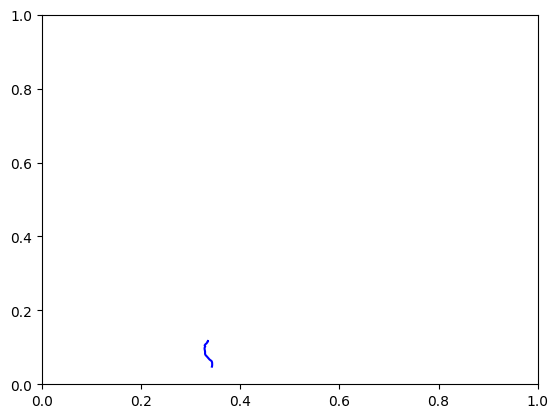

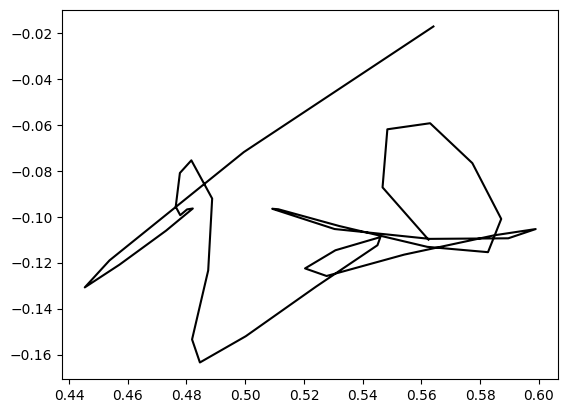

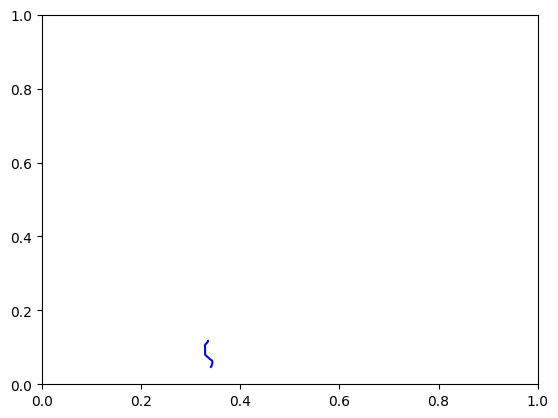

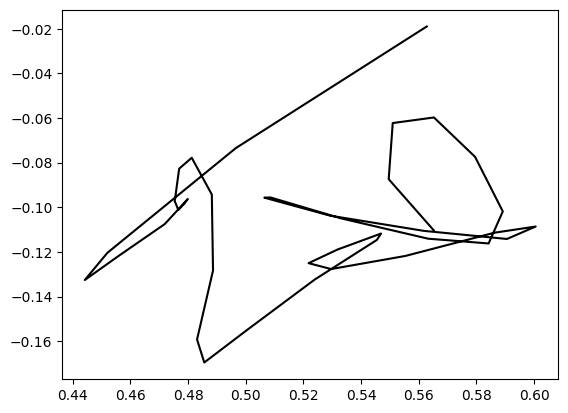

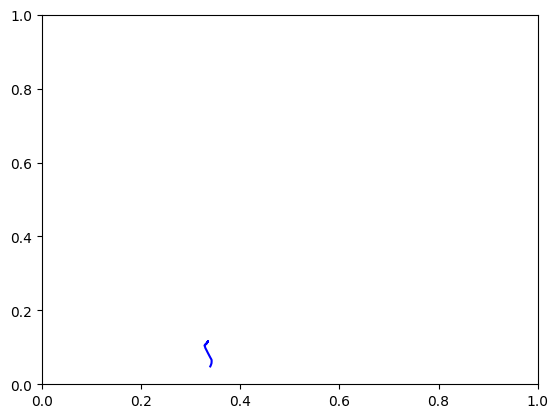

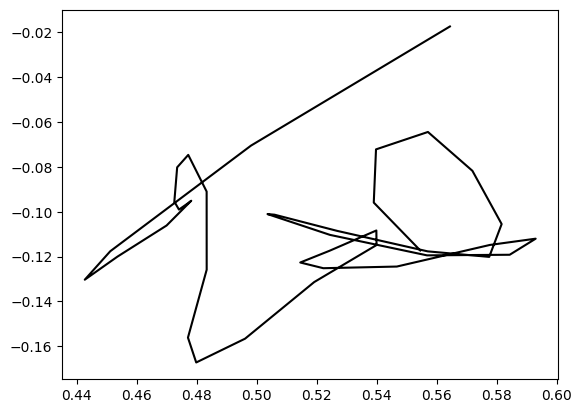

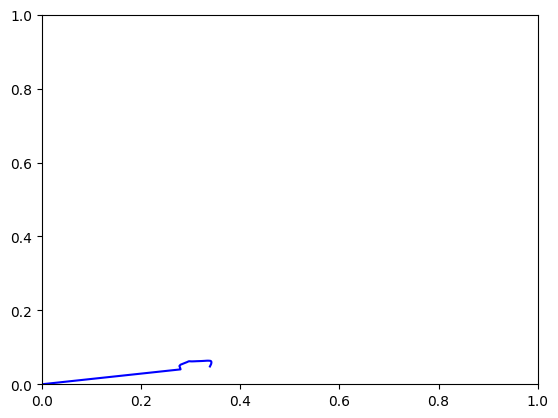

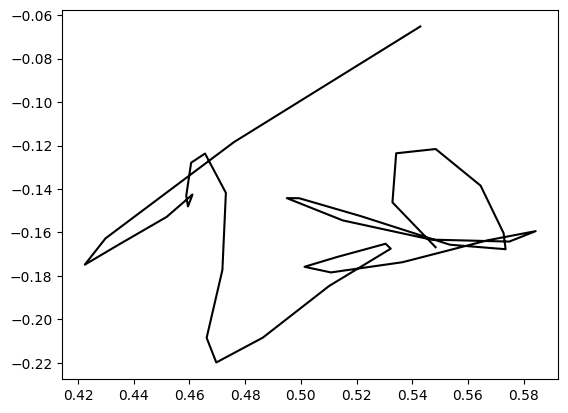

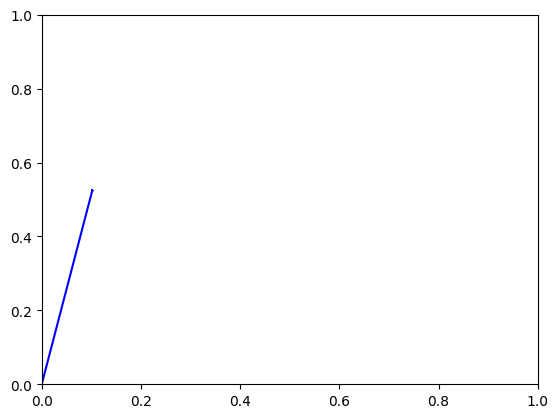

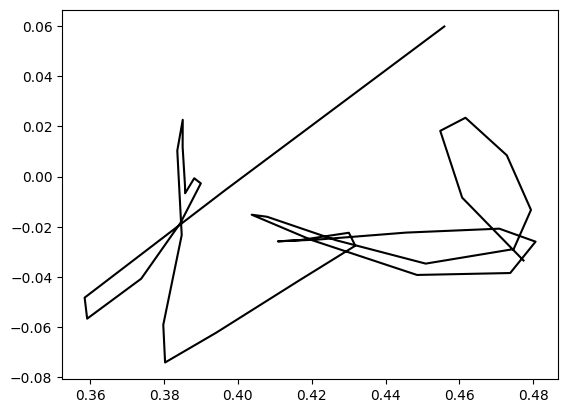

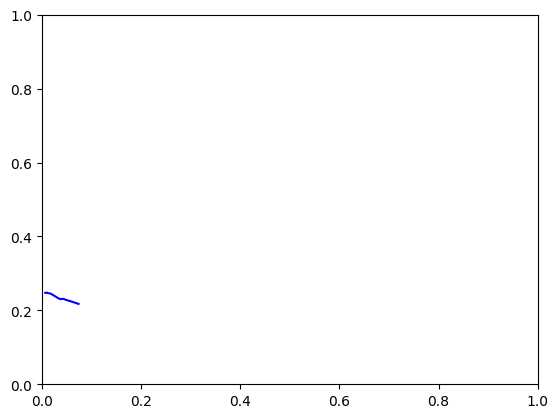

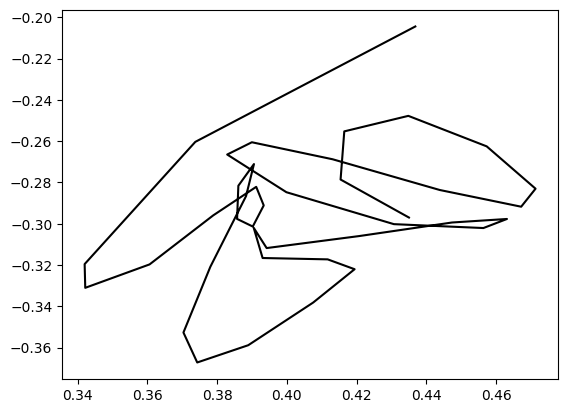

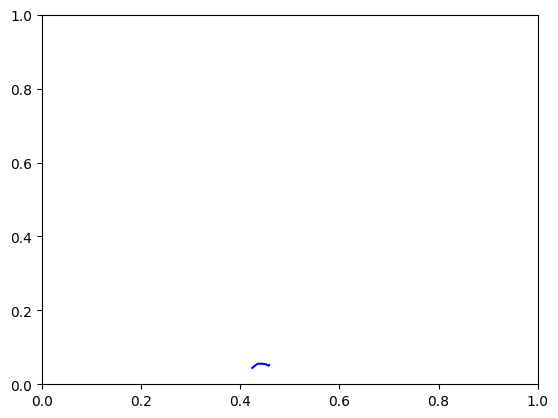

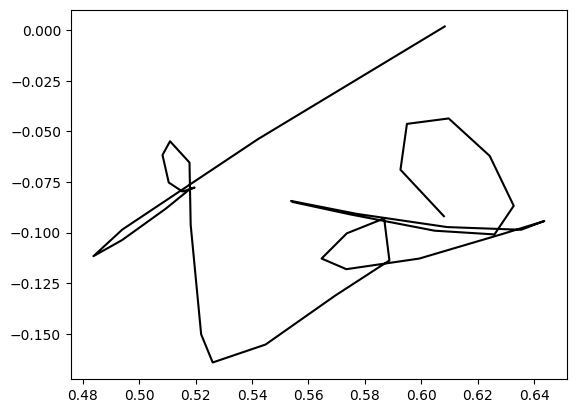

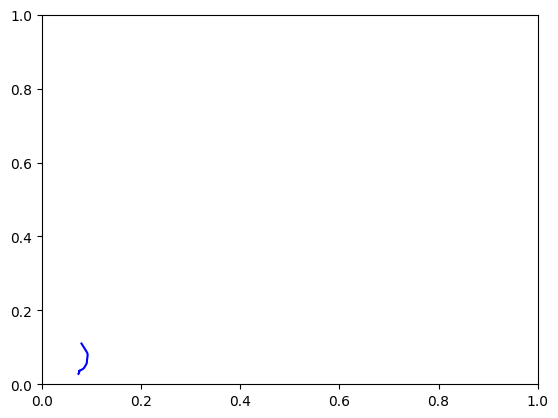

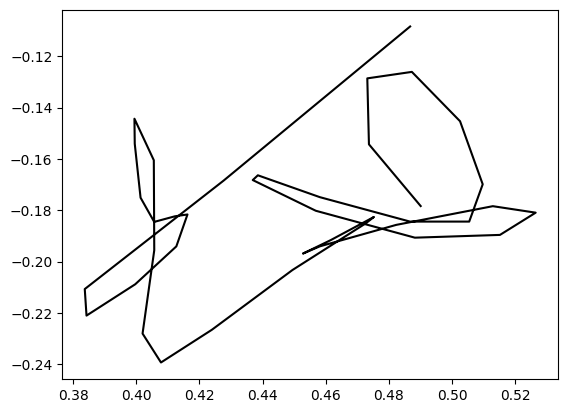

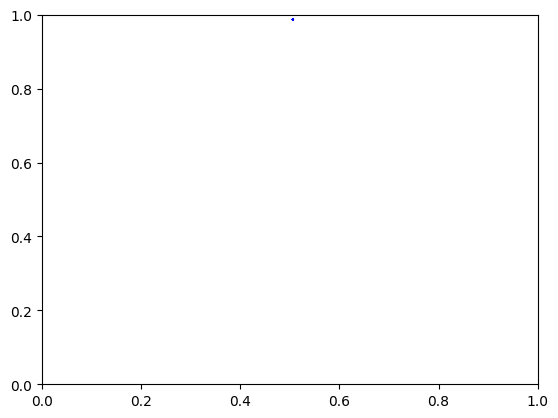

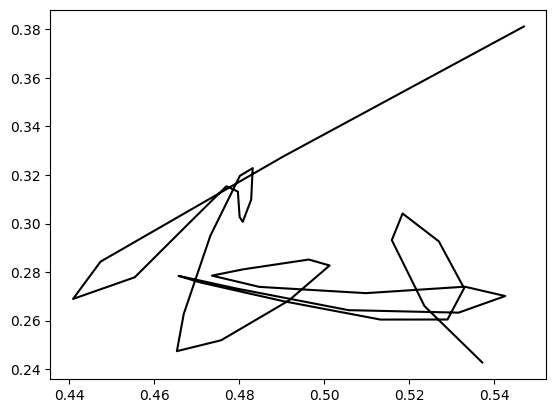

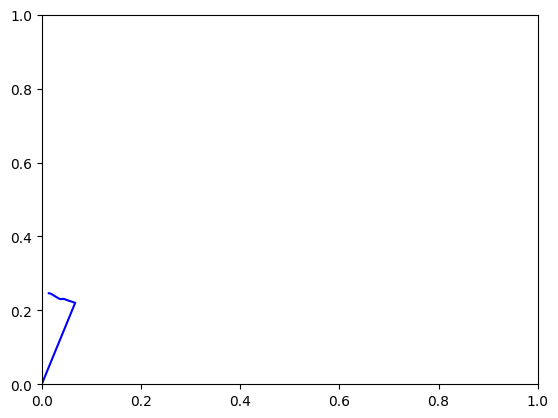

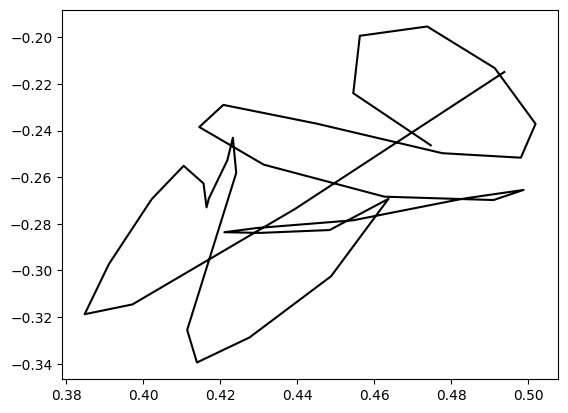

In [101]:
for i in range(10):
    print_paths(30+i)


In [83]:
print(model_y)
print(meas_y)


[0.2375458925962448, 0.23754587769508362, 0.23754587769508362, 0.23754587769508362, 0.2375458925962448, 0.23754587769508362, 0.23754586279392242, 0.237545907497406, 0.23754586279392242, 0.2375458925962448, 0.23754586279392242, 0.23754587769508362, 0.2375458925962448, 0.237545907497406, 0.23754586279392242, 0.2375458925962448, 0.237545907497406, 0.23754586279392242, 0.2375458925962448, 0.2375458925962448, 0.237545907497406, 0.23754586279392242, 0.23754587769508362, 0.23754587769508362, 0.2375458925962448, 0.23754587769508362, 0.23754586279392242, 0.2375458925962448, 0.23754587769508362, 0.23754587769508362, 0.2375458925962448, 0.2375458925962448, 0.23754586279392242, 0.237545907497406, 0.2375458925962448, 0.23754587769508362, 0.23754586279392242, 0.23754587769508362, 0.23754587769508362, 0.23754587769508362]
[0.04961248114705086, 0.05143554508686066, 0.053242336958646774, 0.055019352585077286, 0.056329146027565, 0.056735701858997345, 0.05678246542811394, 0.056576699018478394, 0.05628815

In [17]:
model.eval()

Ei = training_data[:,2,:] # One boats travel path 
print(Ei.size())


Eei = model.encoder.input_proj(Ei) # projected into the embedding space by the encoder 
print(Eei.size())
alfa = model.decoder.output_proj(model.decoder.transformer_decoder(Eei, model.encoder(Ei)))

beta = alfa.squeeze()
print(beta.size())

Eis = Ei.squeeze().detach().numpy()
print(Eis[:])
print(beta.detach().numpy())
print(Eis- beta.detach().numpy())

torch.Size([40, 4])


SyntaxError: 'return' outside function (505041136.py, line 6)